# Machine Learning Models
The following classification models are carried out here:
    1. Random Forest
    2. Support Vector Machines
    3. Feed-forward Neural Networks

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import collections
import sklearn
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.ensemble
import sklearn.multioutput
import sklearn.neural_network


%matplotlib inline

# 1. Load in data

In [2]:
X_16 = pd.read_csv('../../../Data/model_inputs/gdf_2016_X.csv')
y_16 = pd.read_csv('../../../Data/model_inputs/gdf_2016_y.csv')
X_17 = pd.read_csv('../../../Data/model_inputs/gdf_2017_X.csv')
y_17 = pd.read_csv('../../../Data/model_inputs/gdf_2017_y.csv')

In [3]:
X_16.head()

id_trip  mode_f  duration   distance_m  magnitude  carddir_f  start_down  \
0  1724206       0       460   415.236330   0.227492          0           1   
1  1889461       1       447  1843.264582   0.470022          0           1   
2  1724219       2       591  2657.421830   0.303495          1           1   
3  2071991       3       844  2761.792383   0.223787          2           1   
4  1667922       3      1211  1068.301088   0.293601          3           1   

   end_downto  weekday  temporal_c    precip  temperatur  startrush  endrush  \
0           1        1           3  0.000002   28.012522          0        0   
1           1        1           5  0.000134   25.844886          1        1   
2           1        1           3  0.000240   25.389363          0        0   
3           1        1           5  0.001427   24.930720          1        1   
4           1        1           4  0.001429   21.769356          0        0   

   thrurush  startclust  endclust  land_use_s_f  land_use_e_f  
0         0           9         9             0             0  
1         1           0         0             1             1  
2         0           0         9             1             0  
3         1           9         9             0             4  
4         0           0         0             0             0

In [4]:
y_16.head()

purpose_f
0          0
1          1
2          0
3          2
4          2

#### *Important* Temporary work-around code to make the factor codes the same between 2016 & 2017 
TODO: need to move to all_preprocessing notebook to standardize

In [5]:
purpose_code_16 = {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4, 'pick_up_drop_off': 5, 'education': 6, 'health': 7}
purpose_code_17 = {'pick_up_drop_off': 0, 'work': 1, 'shops': 2, 'returning_home': 3, 'health': 4, 'leisure': 5, 'education': 6, 'food_drink': 7}
mode_code_16 = {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'public_transport, car': 4, 'other': 5}
mode_code_17 = {'car': 0, 'public_transport': 1, 'walking': 2, 'cycling': 3, 'public_transport, car': 4, 'other': 5}

def swap_codes(code_16, code_17, row):
    # reverse
    code_17 = dict(zip(code_17.values(),code_17.keys()))
    # make translation
    return code_16[code_17[row]]

# to stop user switching back
if X_17['mode_f'].values[0] == 0:
    y_17['purpose_f'] = y_17['purpose_f'].apply(lambda row: swap_codes(purpose_code_16, purpose_code_17, row))
    X_17['mode_f'] = X_17['mode_f'].apply(lambda row: swap_codes(mode_code_16, mode_code_17, row))

##### Dependent variable class sizes
Purpose: {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4, 'pick_up_drop_off': 5, 'education': 6, 'health': 7} 
  
Mode: {'walking': 0, 'public_transport': 1, 'car': 2, 'cycling': 3, 'public_transport, car': 4, 'other': 5}

In [6]:
print('Dependent variable class sizes 2016:')
y_16['purpose_f'].value_counts()

Dependent variable class sizes 2016:


0    15554
4    14981
1     7430
2     5790
3     5682
5     2473
6     2262
7     2168
Name: purpose_f, dtype: int64

In [7]:
print('Dependent variable class sizes 2017:')
y_17['purpose_f'].value_counts()

Dependent variable class sizes 2017:


0    22464
4    15851
1     8049
3     7723
2     2714
6     2175
5     1379
7      908
Name: purpose_f, dtype: int64

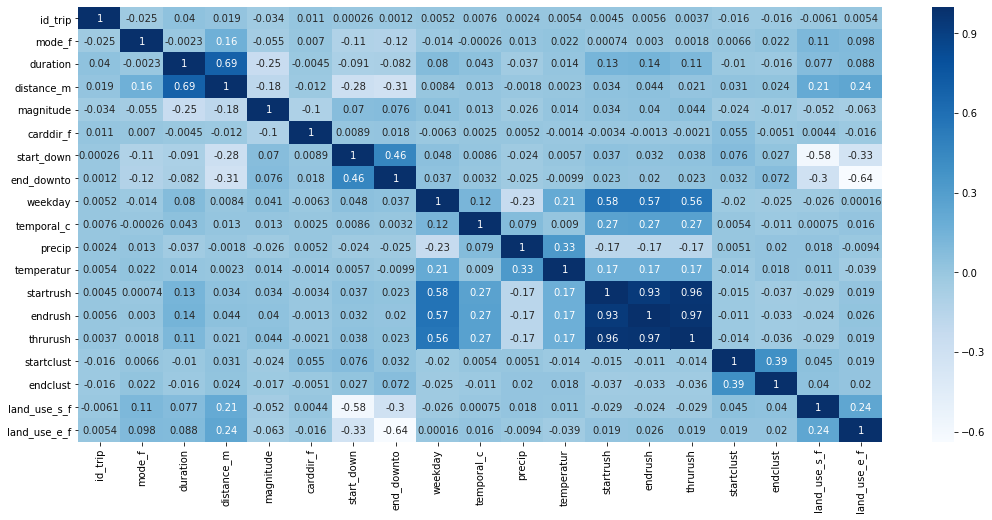

In [8]:
ax, fig = plt.subplots(1, figsize=(18,8))
sns.heatmap(X_16.corr(), cmap='Blues', annot=True)

# 2. Setup model
#### Section Overview:
2.1  Split data into training and testing  
2.2  Prepare train/test data for modelling

In [9]:
# define main data
all_X = X_17.copy()
all_y = y_17.copy()

### 2.1 Split data into training and testing

In [10]:
def normalise(X):
    """
        Feature scaling method.
        Normalises an array between 0–1 by dividing each value by the max in each row
        TODO: change to Min/Max
    """
    X = X / np.amax(X, axis=0)
    return X


def model_setup(X, y, test_size=0.33, norm=False):
    """
        All operations needed for preparing the model inputs.
        Can apply normalisation and then will apply the train/test split
    """
    if norm:
        X = normalise(X)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=test_size,\
                                                                                random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test    

##### IMPORTANT
Train Test Split for encoded and non-encoded

In [11]:
# Train Test Split
X_train, X_test, y_train, y_test  = model_setup(all_X, all_y, norm=True, test_size=0.33)

In [12]:
X_train.head()

id_trip  mode_f  duration  distance_m  magnitude  carddir_f  \
33061  0.268458     0.4  0.267816    0.374015   0.395292   0.933333   
13652  0.205469     0.0  0.046949    0.002006   0.999896   0.800000   
39303  0.151959     0.2  0.020401    0.001737   0.999998   0.266667   
36636  0.794424     0.0  0.024406    0.004738   0.625853   0.133333   
37620  0.868103     0.0  0.376153    0.086293   0.502771   0.266667   

       start_down  end_downto  weekday  temporal_c    precip  temperatur  \
33061         0.0         0.0      1.0         0.4  0.175820    0.455345   
13652         1.0         1.0      1.0         0.6  0.081806    0.462161   
39303         1.0         1.0      1.0         0.2  0.000381    0.535933   
36636         1.0         1.0      1.0         0.2  0.000000    0.409384   
37620         1.0         1.0      1.0         1.0  0.000351    0.498281   

       startrush  endrush  thrurush  startclust  endclust  land_use_s_f  \
33061        1.0      0.0       0.0    0.363636  0.272727      0.111111   
13652        0.0      0.0       0.0    0.090909  0.090909      0.000000   
39303        0.0      0.0       0.0    0.181818  0.181818      0.222222   
36636        1.0      1.0       1.0    0.181818  0.181818      0.000000   
37620        1.0      1.0       1.0    0.181818  0.454545      0.666667   

       land_use_e_f  
33061      0.111111  
13652      0.000000  
39303      0.222222  
36636      0.222222  
37620      0.000000

### 2.2  Prepare train/test data for modelling

In [13]:
training_ids = X_train['id_trip']
X_train = X_train.drop('id_trip', axis=1)
testing_ids = X_test['id_trip']
X_test = X_test.drop('id_trip', axis=1)

In [14]:
## flatten data i.e. from Pd.Series to np.array
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [15]:
feature_list = list(X_train.columns)
print('all_features:\n\n', feature_list)

all_features:

 ['mode_f', 'duration', 'distance_m', 'magnitude', 'carddir_f', 'start_down', 'end_downto', 'weekday', 'temporal_c', 'precip', 'temperatur', 'startrush', 'endrush', 'thrurush', 'startclust', 'endclust', 'land_use_s_f', 'land_use_e_f']


In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41046 entries, 33061 to 24916
Data columns (total 18 columns):
mode_f          41046 non-null float64
duration        41046 non-null float64
distance_m      41046 non-null float64
magnitude       41046 non-null float64
carddir_f       41046 non-null float64
start_down      41046 non-null float64
end_downto      41046 non-null float64
weekday         41046 non-null float64
temporal_c      41046 non-null float64
precip          41046 non-null float64
temperatur      41046 non-null float64
startrush       41046 non-null float64
endrush         41046 non-null float64
thrurush        41046 non-null float64
startclust      41046 non-null float64
endclust        41046 non-null float64
land_use_s_f    41046 non-null float64
land_use_e_f    41046 non-null float64
dtypes: float64(18)
memory usage: 5.9 MB


# 3. Begin Modelling
#### Section Overview:
3.1 Define model functions and test modelling   
3.2 Preliminary modelling for important feature extraction  
3.3 Re-run models  

#### Model functions:
- `run_rf` == run the random forest classification model.
- `run_sv` == run the support vector machine classification model.
- `run_ann` == run the multi-layer perceptron classification model.  
- `run_mcrf` == *Experimental* run the multi-output random forest classification model.

#### Notes:

#### Technical Notes:
- each model will have a cross-validation option. To use this the function parameters will need to be set to `cv=True` and `cv_val` to the number of k-folds defaulting to `cv_val=5`

### 3.1 Define model functions and test

In [17]:
# All Model functions
def run_rf(X_train, X_test, y_train, y_test, n_estimators=10, cv=False, cv_val=5):
    """
        Run a random forest classification model with option to use cross-validation
    """
    cv_scores = []
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1)
    if cv:
        cv_scores = sklearn.model_selection.cross_val_score(clf, X_train, y_train, cv=cv_val)
        print("cv scores:",cv_scores)
    clf.fit(X_train, y_train)
    score = clf.score(X_test,y_test)
    preds = clf.predict(X_test)
    print("Random Forest Classifcation accuracy:", score)
    return clf, score, preds, cv_scores


def run_svc(X_train, X_test, y_train, y_test, gamma_val=0.01, C_val=0.1, cv=False, cv_val=5):
    """
        Run a support vector classification model with option to use cross-validation
    """
    cv_scores = []
    if cv:
        clf = sklearn.svm.SVC(gamma=gamma_val, C=C_val, decision_function_shape='ova')
        cv_scores = sklearn.model_selection.cross_val_score(clf, X_train, y_train, cv=cv_val)
        print("cv scores:",cv_scores)
    clf = sklearn.svm.SVC(gamma=gamma_val, C=C_val, decision_function_shape='ova')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    preds = clf.predict(X_test)  
    print("Support Vector classification accuracy:", score)
    return score, preds, cv_scores


def run_ann(X_train, X_test, y_train, y_test, alpha_val=0.01, C_val=0.1, cv=False, cv_val=5):
    """
        Run a neural network classification model with option to use cross-validation
    """
    cv_scores = []
    if cv:
        clf = sklearn.neural_network.MLPClassifier(solver='lbfgs', alpha=alpha_val,\
                                            hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=500)
        cv_scores = sklearn.model_selection.cross_val_score(clf,X_train,y_train, cv=cv_val)
        print("cv scores:",cv_scores)
    clf = sklearn.neural_network.MLPClassifier(solver='lbfgs', alpha=alpha_val,\
                                               hidden_layer_sizes=(50, 50, 50), random_state=1, max_iter=500)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    preds = clf.predict(X_test)
    print("Neural Network classification accuracy:", score)
    return score, preds, cv_scores


## Experimental
def run_mcrf(X_train, X_test, y_train, y_test, n_estimators=10, cv=False, cv_val=5):
    """
        Not currently in use.
        Run a multi-ouput random forest classification model with option to use cross-validation
    """
    cv_scores = []
    clf = sklearn.ensemble.RandomForestClassifier(n_estimators = n_estimators,\
                                                  criterion = 'entropy', random_state = 42)
    multi_target_forest = sklearn.multioutput.MultiOutputClassifier(clf, n_jobs=-1)
    if cv:
        cv_scores = sklearn.model_selection.cross_val_score(multi_target_forest, X_train, y_train, cv=cv_val)
        print("cv scores:",cv_scores)
    multi_target_forest.fit(X_train, y_train)
    score = multi_target_forest.score(X_test, y_test)
    preds = multi_target_forest.predict(X_test)
    print("Multi-output Random Forest classification accuracy:", score)
    return score, preds, cv_scores

#### 3.1.1 test models

In [18]:
%%time
_, _, _, _ = run_rf(X_train, X_test, y_train, y_test,cv=False)

Random Forest Classifcation accuracy: 0.5226789335707572
CPU times: user 1.28 s, sys: 64.4 ms, total: 1.34 s
Wall time: 648 ms


In [19]:
%%time
_, _, _, _ = run_rf(X_train, X_test, y_train, y_test,cv=True)

cv scores: [0.52593765 0.51747656 0.51741778 0.52162788 0.52412869]
Random Forest Classifcation accuracy: 0.5266359994064401
CPU times: user 1.92 s, sys: 651 ms, total: 2.57 s
Wall time: 5.79 s


In [20]:
%%time
_, _, _ = run_svc(X_train, X_test, y_train, y_test,cv=False)

Support Vector classification accuracy: 0.4259781372112579
CPU times: user 3min 12s, sys: 5.1 s, total: 3min 17s
Wall time: 3min 41s


In [21]:
%%time
_, _, _ = run_svc(X_train, X_test, y_train, y_test,cv=True)

cv scores: [0.41731612 0.41432225 0.41144945 0.40428902 0.41518401]
Support Vector classification accuracy: 0.4259781372112579
CPU times: user 10min 16s, sys: 15.2 s, total: 10min 31s
Wall time: 11min 8s


In [22]:
%%time
_, _, _ = run_ann(X_train, X_test, y_train, y_test,cv=False)

Neural Network classification accuracy: 0.5470643517831528
CPU times: user 2min 10s, sys: 10.1 s, total: 2min 20s
Wall time: 1min 10s


In [23]:
%%time
_, _, _ = run_ann(X_train, X_test, y_train, y_test,cv=True)

cv scores: [0.54006332 0.54195591 0.53447016 0.54039235 0.54277358]
Neural Network classification accuracy: 0.5470643517831528
CPU times: user 10min 55s, sys: 51.1 s, total: 11min 46s
Wall time: 6min 4s


### 3.2 Run RF to subset data features by the feature importance metric

In [24]:
def calc_feature_imp(clf, feature_list, threshold):
    """
        function for extracting feature importance from rf model then prepare the
        data for subsetting based on a threshold of the relative feature importance metric
    """
    # Get numerical feature importances
    importances = list(clf.feature_importances_)
    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 5)) for feature, importance in zip(feature_list, importances)]
    print(feature_importances)
    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    above_threshold = [i[0] if i[1] >= threshold else "" for i in feature_importances]
    return feature_importances, above_threshold


def subset_to_imp_features(data, above_threshold):
    """
        function for subsetting the training/test data to only input features with feature
        importance above the threshold
    """
    above_threshold.append("id_trip")
    data = data[data.columns[[col in above_threshold for col in data.columns]]]
    return data


def plot_feature_imp(feature_importances, title):    
    """
        function for plotting the feature importance from the RF model of all the input features
    """
    fig, ax = plt.subplots(1, figsize=(10,6))
    feat_imp = pd.DataFrame(feature_importances, columns=['importance', 'feature'])
    feat_imp = feat_imp.loc[(feat_imp.importance != 'id_trip')]
    feat_imp.plot(kind='barh', ax=ax, legend=False)
    ax.set_yticklabels([new_column_labels[i] for i in list(feat_imp.importance.values)], size=16);
    plt.xticks(size=16);
    ax.set_xlim(0,0.2)
    ax.axvline(0.05, -10,40, color='r',linestyle='--')
    ax.set_xlabel("Feature Importance", size=20)
    ax.set_ylabel("Feature", size=20)
    ax.set_title("{0}".format(title), size=22)
    return ax

In [25]:
# Train Test Split
X_train, X_test, y_train, y_test  = model_setup(all_X, all_y, norm=True, test_size=0.33)
feature_list = list(X_train.columns)
training_ids = X_train['id_trip']
X_train = X_train.drop('id_trip', axis=1)
testing_ids = X_test['id_trip']
X_test = X_test.drop('id_trip', axis=1)

# run a model
clf, _, _, _ = run_rf(X_train, X_test, y_train, y_test,cv=False)
# extract feature importances
feature_importances, above_thresh = calc_feature_imp(clf, feature_list, threshold=0.01)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Random Forest Classifcation accuracy: 0.5304446752732849
[('id_trip', 0.04241), ('mode_f', 0.11773), ('duration', 0.12265), ('distance_m', 0.11757), ('magnitude', 0.08143), ('carddir_f', 0.00654), ('start_down', 0.00586), ('end_downto', 0.02538), ('weekday', 0.06165), ('temporal_c', 0.079), ('precip', 0.11666), ('temperatur', 0.00776), ('startrush', 0.0093), ('endrush', 0.00612), ('thrurush', 0.0438), ('startclust', 0.04168), ('endclust', 0.03919), ('land_use_s_f', 0.07527)]


In [26]:
above_thresh[:]

['duration',
 'mode_f',
 'distance_m',
 'precip',
 'magnitude',
 'temporal_c',
 'land_use_s_f',
 'weekday',
 'thrurush',
 'id_trip',
 'startclust',
 'endclust',
 'end_downto',
 '',
 '',
 '',
 '',
 '']

In [27]:
feature_importances

[('duration', 0.12265),
 ('mode_f', 0.11773),
 ('distance_m', 0.11757),
 ('precip', 0.11666),
 ('magnitude', 0.08143),
 ('temporal_c', 0.079),
 ('land_use_s_f', 0.07527),
 ('weekday', 0.06165),
 ('thrurush', 0.0438),
 ('id_trip', 0.04241),
 ('startclust', 0.04168),
 ('endclust', 0.03919),
 ('end_downto', 0.02538),
 ('startrush', 0.0093),
 ('temperatur', 0.00776),
 ('carddir_f', 0.00654),
 ('endrush', 0.00612),
 ('start_down', 0.00586)]

In [28]:
subset_X = subset_to_imp_features(all_X,above_thresh)

In [29]:
subset_X.head()

id_trip  mode_f  duration    distance_m  magnitude  end_downto  weekday  \
0   150744       2       862   9935.922336   0.304086           1        1   
1   173651       2      2856  15283.760539   0.232414           0        1   
2   149086       1      2972   7693.525202   0.048575           1        1   
3   358412       0       768    992.314303   0.347807           1        1   
4   350121       2      2370  33250.148027   0.338182           0        1   

   temporal_c        precip  thrurush  startclust  endclust  land_use_s_f  
0           4  0.000000e+00         1           1         6             0  
1           2  9.972328e-07         0           3         3             1  
2           2  9.972328e-07         0           2         2             2  
3           2  9.972328e-07         0           2         2             3  
4           2  9.972328e-07         0           0         0             1

### 3.3 Re-build the models with new subset data

#### Note:

purpose = {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4, 'pick_up_drop_off': 5, 'education': 6, 'health': 7}  

In [30]:
# Train Test Split
X_train, X_test, y_train, y_test = model_setup(subset_X, all_y, norm=True, test_size=0.33)

In [31]:
training_ids = X_train['id_trip']
X_train = X_train.drop('id_trip', axis=1)
testing_ids = X_test['id_trip']
X_test = X_test.drop('id_trip', axis=1)

In [32]:
rf_clf, rf_score, rf_preds, rf_cv_scores = run_rf(X_train, X_test, y_train, y_test)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


Random Forest Classifcation accuracy: 0.4830093485680368


In [33]:
print('predictions for each class by RF:', collections.Counter(rf_preds), '\n')
# {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4,
# 'pick_up_drop_off': 5, 'education': 6, 'health': 7}
print(sklearn.metrics.classification_report(y_test, rf_preds))

predictions for each class by RF: Counter({0: 10575, 4: 5346, 1: 1938, 3: 1775, 2: 344, 6: 146, 5: 60, 7: 33}) 

              precision    recall  f1-score   support

           0       0.51      0.73      0.60      7413
           1       0.26      0.19      0.22      2656
           2       0.15      0.06      0.09       896
           3       0.28      0.19      0.23      2548
           4       0.61      0.62      0.62      5231
           5       0.12      0.02      0.03       455
           6       0.21      0.04      0.07       718
           7       0.03      0.00      0.01       300

    accuracy                           0.48     20217
   macro avg       0.27      0.23      0.23     20217
weighted avg       0.43      0.48      0.44     20217



In [34]:
svc_score, svc_preds, svc_cv_score = run_svc(X_train, X_test, y_train, y_test)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Support Vector classification accuracy: 0.3833407528317752


In [35]:
print('predictions for each class by SVC:', collections.Counter(svc_preds), '\n')
# {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4,
# 'pick_up_drop_off': 5, 'education': 6, 'health': 7}
print(sklearn.metrics.classification_report(y_test, svc_preds))

predictions for each class by SVC: Counter({0: 16730, 4: 3487}) 

              precision    recall  f1-score   support

           0       0.39      0.88      0.54      7413
           1       0.00      0.00      0.00      2656
           2       0.00      0.00      0.00       896
           3       0.00      0.00      0.00      2548
           4       0.34      0.23      0.27      5231
           5       0.00      0.00      0.00       455
           6       0.00      0.00      0.00       718
           7       0.00      0.00      0.00       300

    accuracy                           0.38     20217
   macro avg       0.09      0.14      0.10     20217
weighted avg       0.23      0.38      0.27     20217



/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [36]:
nn_score, nn_preds, nn_cv_score = run_ann(X_train, X_test, y_train, y_test)

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Neural Network classification accuracy: 0.5144185586387694


In [37]:
print('predictions for each class by ANN:', collections.Counter(nn_preds), '\n')
# {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4,
# 'pick_up_drop_off': 5, 'education': 6, 'health': 7}
print(sklearn.metrics.classification_report(y_test, nn_preds))

predictions for each class by ANN: Counter({0: 11233, 4: 6244, 3: 1392, 1: 1323, 2: 24, 6: 1}) 

              precision    recall  f1-score   support

           0       0.52      0.79      0.63      7413
           1       0.35      0.17      0.23      2656
           2       0.12      0.00      0.01       896
           3       0.35      0.19      0.24      2548
           4       0.58      0.69      0.63      5231
           5       0.00      0.00      0.00       455
           6       0.00      0.00      0.00       718
           7       0.00      0.00      0.00       300

    accuracy                           0.51     20217
   macro avg       0.24      0.23      0.22     20217
weighted avg       0.44      0.51      0.45     20217



/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 4 Improve models
### Overview:
4.1 Encode model inputs (for ANN/SVC)  

### 4.1 Encode model inputs
The model inputs are encoded to improve the performance of ANN/SVC models. Specifically by One-hot encoding all the 

#### Encoded inputs:
- Trip mode *(f)*
- Cardinal Direction *(f)*
- Trip starting & ending cluster from K-means (see `./Notebooks/preprocessing/metric_creation/clustering.ipynb`)
- Temporal cluster from LDA
- Land-use at trip starting and ending points *(f)* (see `./Notebooks/preprocessing/metric_creation/land_use_poi.ipynb`)

*(f) == factors*

#### Note:
- for factor numbers see Data/model_inputs folder e.g. `./Data/model_inputs/gdf_2016_land_use_factors.txt`

In [70]:
# for One Hot Encoded data
enc_X = subset_X.copy()
enc_y = all_y.copy()

In [71]:
def encode_model_inputs(data, col):
    """
        function for applying a OneHotEncoder to a input feature 
    """
    encoded_input = ''
    if col in data.columns:
        encoded_input = enc.fit_transform(data[col].values.reshape(-1, 1)).toarray()
    return encoded_input


In [72]:
enc = sklearn.preprocessing.OneHotEncoder(handle_unknown='ignore')


In [73]:
encoded_inputs = {}
for col in ["mode_f","carddir_f","startclust","endclust", "temporal_c", "land_use_s_f", "land_use_e_f"]:
    if col in enc_X.columns:
        # 1. encode inputs
        encoded_inputs[col] = encode_model_inputs(enc_X, col)
        # 2. make a temporary df with encoded inputs and column names of format *col*_*factor*
        col_df = pd.DataFrame(encoded_inputs[col], columns=['%s_%s' % (col, i) for i in range(encoded_inputs[col].shape[1])])
        # 3. drop column from main data so that they can be concatenated
        enc_X = enc_X.drop(col, axis=1)
        # 4. concatenate the two data sets
        enc_X = pd.concat([enc_X, col_df], axis=1)

encoded_inputs['purpose_f'] = encode_model_inputs(enc_y, 'purpose_f')

# for multi-output predictions
multi_output_y = pd.DataFrame(encode_model_inputs(enc_y, 'purpose_f'), columns=['%s_%s' % ('purpose_f', i) for i in range(encoded_inputs['purpose_f'].shape[1])])


In [74]:
# view new data with columns following the *col*_*factor* syntax
enc_X.columns

Index(['id_trip', 'duration', 'distance_m', 'magnitude', 'end_downto',
       'weekday', 'precip', 'thrurush', 'mode_f_0', 'mode_f_1', 'mode_f_2',
       'mode_f_3', 'mode_f_4', 'mode_f_5', 'startclust_0', 'startclust_1',
       'startclust_2', 'startclust_3', 'startclust_4', 'startclust_5',
       'startclust_6', 'startclust_7', 'startclust_8', 'startclust_9',
       'startclust_10', 'startclust_11', 'endclust_0', 'endclust_1',
       'endclust_2', 'endclust_3', 'endclust_4', 'endclust_5', 'endclust_6',
       'endclust_7', 'endclust_8', 'endclust_9', 'endclust_10', 'endclust_11',
       'temporal_c_0', 'temporal_c_1', 'temporal_c_2', 'temporal_c_3',
       'temporal_c_4', 'land_use_s_f_0', 'land_use_s_f_1', 'land_use_s_f_2',
       'land_use_s_f_3', 'land_use_s_f_4', 'land_use_s_f_5', 'land_use_s_f_6',
       'land_use_s_f_7', 'land_use_s_f_8', 'land_use_s_f_9'],
      dtype='object')

In [75]:
# example of multi-output encoded inputs
multi_output_y.head()

purpose_f_0  purpose_f_1  purpose_f_2  purpose_f_3  purpose_f_4  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          1.0   
2          0.0          0.0          0.0          0.0          1.0   
3          0.0          0.0          0.0          0.0          1.0   
4          0.0          0.0          0.0          0.0          1.0   

   purpose_f_5  purpose_f_6  purpose_f_7  
0          1.0          0.0          0.0  
1          0.0          0.0          0.0  
2          0.0          0.0          0.0  
3          0.0          0.0          0.0  
4          0.0          0.0          0.0

In [76]:
%%time
# multi-output
multi_X_train, multi_X_test, multi_y_train, multi_y_test  = model_setup(all_X, multi_output_y, norm=True, test_size=0.33)
_, _, _ = run_mcrf(multi_X_train, multi_X_test, multi_y_train, multi_y_test,cv=False)

Multi-output Random Forest classification accuracy: 0.32893109759113615
CPU times: user 1.04 s, sys: 414 ms, total: 1.46 s
Wall time: 7.1 s


## 4.2 Re-run ANN/SVC with encoded inputs

In [77]:
# Train Test Split
enc_X_train, enc_X_test, enc_y_train, enc_y_test  = model_setup(enc_X, enc_y, norm=True, test_size=0.33)

In [78]:
enc_training_ids = enc_X_train['id_trip']
enc_X_train = enc_X_train.drop('id_trip', axis=1)
enc_testing_ids = enc_X_test['id_trip']
enc_X_test = enc_X_test.drop('id_trip', axis=1)

In [79]:
## flatten data i.e. from Pd.Series to np.array
enc_y_train = np.ravel(enc_y_train)
enc_y_test = np.ravel(enc_y_test)

In [80]:
enc_feature_list = list(enc_X_train.columns)
print('all_features:\n\n', enc_feature_list)

all_features:

 ['duration', 'distance_m', 'magnitude', 'end_downto', 'weekday', 'precip', 'thrurush', 'mode_f_0', 'mode_f_1', 'mode_f_2', 'mode_f_3', 'mode_f_4', 'mode_f_5', 'startclust_0', 'startclust_1', 'startclust_2', 'startclust_3', 'startclust_4', 'startclust_5', 'startclust_6', 'startclust_7', 'startclust_8', 'startclust_9', 'startclust_10', 'startclust_11', 'endclust_0', 'endclust_1', 'endclust_2', 'endclust_3', 'endclust_4', 'endclust_5', 'endclust_6', 'endclust_7', 'endclust_8', 'endclust_9', 'endclust_10', 'endclust_11', 'temporal_c_0', 'temporal_c_1', 'temporal_c_2', 'temporal_c_3', 'temporal_c_4', 'land_use_s_f_0', 'land_use_s_f_1', 'land_use_s_f_2', 'land_use_s_f_3', 'land_use_s_f_4', 'land_use_s_f_5', 'land_use_s_f_6', 'land_use_s_f_7', 'land_use_s_f_8', 'land_use_s_f_9']


In [81]:
enc_svc_score, enc_svc_preds, enc_svc_cv_score = run_svc(enc_X_train, enc_X_test, enc_y_train, enc_y_test)

Support Vector classification accuracy: 0.4791017460553


In [82]:
print('predictions for each class by SVC with encoded inputs:', collections.Counter(enc_svc_preds), '\n')
# {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4,
# 'pick_up_drop_off': 5, 'education': 6, 'health': 7}
print(sklearn.metrics.classification_report(enc_y_test, enc_svc_preds))

predictions for each class by SVC with encoded inputs: Counter({0: 14825, 4: 5392}) 

              precision    recall  f1-score   support

           0       0.45      0.89      0.59      7413
           1       0.00      0.00      0.00      2656
           2       0.00      0.00      0.00       896
           3       0.00      0.00      0.00      2548
           4       0.57      0.59      0.58      5231
           5       0.00      0.00      0.00       455
           6       0.00      0.00      0.00       718
           7       0.00      0.00      0.00       300

    accuracy                           0.48     20217
   macro avg       0.13      0.19      0.15     20217
weighted avg       0.31      0.48      0.37     20217



/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [83]:
enc_nn_score, enc_nn_preds, enc_nn_cv_score = run_ann(enc_X_train, enc_X_test, enc_y_train, enc_y_test)

Neural Network classification accuracy: 0.502794677746451


In [84]:
print('predictions for each class by ANN with encoded inputs:', collections.Counter(enc_nn_preds), '\n')
# {'returning_home': 0, 'leisure': 1, 'food_drink': 2, 'shops': 3, 'work': 4,
# 'pick_up_drop_off': 5, 'education': 6, 'health': 7}
print(sklearn.metrics.classification_report(enc_y_test, enc_nn_preds))

predictions for each class by ANN with encoded inputs: Counter({0: 10612, 4: 6007, 1: 1734, 3: 1655, 6: 111, 2: 87, 5: 10, 7: 1}) 

              precision    recall  f1-score   support

           0       0.52      0.75      0.62      7413
           1       0.29      0.19      0.23      2656
           2       0.18      0.02      0.03       896
           3       0.31      0.20      0.24      2548
           4       0.59      0.67      0.63      5231
           5       0.30      0.01      0.01       455
           6       0.32      0.05      0.09       718
           7       0.00      0.00      0.00       300

    accuracy                           0.50     20217
   macro avg       0.32      0.24      0.23     20217
weighted avg       0.45      0.50      0.45     20217



In [85]:
print('SVC before', collections.Counter(svc_preds),'\n')
print(sklearn.metrics.classification_report(y_test, svc_preds))
print('SVC after', collections.Counter(enc_svc_preds),'\n')
print(sklearn.metrics.classification_report(enc_y_test, enc_svc_preds))


print('NN before', collections.Counter(nn_preds),'\n')
print(sklearn.metrics.classification_report(y_test, nn_preds))
print('NN after', collections.Counter(enc_nn_preds),'\n')
print(sklearn.metrics.classification_report(enc_y_test, enc_nn_preds))

SVC before Counter({0: 16730, 4: 3487}) 

              precision    recall  f1-score   support

           0       0.39      0.88      0.54      7413
           1       0.00      0.00      0.00      2656
           2       0.00      0.00      0.00       896
           3       0.00      0.00      0.00      2548
           4       0.34      0.23      0.27      5231
           5       0.00      0.00      0.00       455
           6       0.00      0.00      0.00       718
           7       0.00      0.00      0.00       300

    accuracy                           0.38     20217
   macro avg       0.09      0.14      0.10     20217
weighted avg       0.23      0.38      0.27     20217

SVC after Counter({0: 14825, 4: 5392}) 

              precision    recall  f1-score   support

           0       0.45      0.89      0.59      7413
           1       0.00      0.00      0.00      2656
           2       0.00      0.00      0.00       896
           3       0.00      0.00      0.00      

/Applications/anaconda/envs/st-ds/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## add POI categories

In [87]:
poi_16 = pd.read_csv('../../../Data/model_inputs/poi_categories_2016.csv')
poi_17 = pd.read_csv('../../../Data/model_inputs/poi_categories_2017.csv')

In [130]:
print('MTL 2016 number of trips with purpose that overlap with a POI within 50 m')
len(X_16.merge(poi_16, on='id_trip', how='inner'))

MTL 2016 number of trips with purpose that overlap with a POI within 50 m


12581

In [131]:
print('MTL 2017 number of trips with purpose that overlap with a POI within 50 m')
len(X_17.merge(poi_17, on='id_trip', how='inner'))

MTL 2017 number of trips with purpose that overlap with a POI within 50 m


27866

In [108]:
merged_X_16 = X_16.merge(poi_16, on='id_trip', how='left')
merged_X_17 = X_17.merge(poi_17, on='id_trip', how='left')

In [109]:
merged_X_16.head()

id_trip  mode_f  duration   distance_m  magnitude  carddir_f  start_down  \
0  1724206       0       460   415.236330   0.227492          0           1   
1  1889461       1       447  1843.264582   0.470022          0           1   
2  1724219       2       591  2657.421830   0.303495          1           1   
3  2071991       3       844  2761.792383   0.223787          2           1   
4  1667922       3      1211  1068.301088   0.293601          3           1   

   end_downto  weekday  temporal_c  ...  Taxi  Tea Room  Theater  \
0           1        1           3  ...   0.0       0.0      0.0   
1           1        1           5  ...   0.0       0.0      0.0   
2           1        1           3  ...   0.0       0.0      0.0   
3           1        1           5  ...   NaN       NaN      NaN   
4           1        1           4  ...   NaN       NaN      NaN   

   Tourist Information Center  Train  Travel Agency  Tv station  Venue  \
0                         0.0    0.0            0.0         0.0    0.0   
1                         0.0    0.0            0.0         0.0    0.0   
2                         0.0    0.0            0.0         0.0    0.0   
3                         NaN    NaN            NaN         NaN    NaN   
4                         NaN    NaN            NaN         NaN    NaN   

   Veterinarian  Yoga Studio  
0           0.0          0.0  
1           0.0          0.0  
2           0.0          0.0  
3           NaN          NaN  
4           NaN          NaN  

[5 rows x 119 columns]

In [119]:
merged_X_16 = merged_X_16.fillna(0)
merged_X_17 = merged_X_17.fillna(0)

In [115]:
X_train, X_test, y_train, y_test = model_setup(merged_X_17, all_y, norm=True, test_size=0.33)

In [117]:
X_train

id_trip  mode_f  duration  distance_m  magnitude  carddir_f  \
33061  0.268458     0.4  0.267816    0.374015   0.395292   0.933333   
13652  0.205469     0.0  0.046949    0.002006   0.999896   0.800000   
39303  0.151959     0.2  0.020401    0.001737   0.999998   0.266667   
36636  0.794424     0.0  0.024406    0.004738   0.625853   0.133333   
37620  0.868103     0.0  0.376153    0.086293   0.502771   0.266667   
...         ...     ...       ...         ...        ...        ...   
55711  0.578387     0.6  0.065487    0.025439   0.459122   0.066667   
49893  0.880832     0.6  0.078901    0.037518   0.445724   0.333333   
17951  0.671337     0.4  0.129017    0.087814   0.284719   0.733333   
51261  0.893903     0.0  0.017327    0.002051   0.580360   0.533333   
24916  0.900707     0.6  0.116069    0.029590   0.596141   0.133333   

       start_down  end_downto  weekday  temporal_c  ...  Tea Room  Theater  \
33061         0.0         0.0      1.0         0.4  ...       NaN      NaN   
13652         1.0         1.0      1.0         0.6  ...       NaN      NaN   
39303         1.0         1.0      1.0         0.2  ...       NaN      NaN   
36636         1.0         1.0      1.0         0.2  ...       NaN      NaN   
37620         1.0         1.0      1.0         1.0  ...       NaN      NaN   
...           ...         ...      ...         ...  ...       ...      ...   
55711         1.0         1.0      0.0         1.0  ...       NaN      NaN   
49893         1.0         1.0      1.0         0.2  ...       NaN      NaN   
17951         0.0         0.0      0.0         1.0  ...       NaN      NaN   
51261         1.0         1.0      1.0         0.4  ...       NaN      NaN   
24916         1.0         1.0      1.0         1.0  ...       NaN      NaN   

       Tourist Information Center  Train  Travel Agency  Travel Lounge  \
33061                         NaN    NaN            NaN            NaN   
13652                         NaN    NaN            NaN            NaN   
39303                         NaN    NaN            NaN            NaN   
36636                         NaN    NaN            NaN            NaN   
37620                         NaN    NaN            NaN            NaN   
...                           ...    ...            ...            ...   
55711                         NaN    NaN            NaN            NaN   
49893                         NaN    NaN            NaN            NaN   
17951                         NaN    NaN            NaN            NaN   
51261                         NaN    NaN            NaN            NaN   
24916                         NaN    NaN            NaN            NaN   

       Tv station  Venue  Veterinarian  Yoga Studio  
33061         NaN    0.0           NaN          NaN  
13652         NaN    0.0           NaN          NaN  
39303         NaN    0.0           NaN          NaN  
36636         NaN    0.0           NaN          NaN  
37620         NaN    0.0           NaN          NaN  
...           ...    ...           ...          ...  
55711         NaN    0.0           NaN          NaN  
49893         NaN    0.0           NaN          NaN  
17951         NaN    0.0           NaN          NaN  
51261         NaN    0.0           NaN          NaN  
24916         NaN    0.0           NaN          NaN  

[41046 rows x 135 columns]

In [116]:
rf_clf, rf_score, rf_preds, rf_cv_scores = run_rf(X_train, X_test, y_train, y_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

## Grid Search

In [86]:
sklearn.model_selection.GridSearchCV

sklearn.model_selection._search.GridSearchCV